# Connect To Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/CMP/"

Mounted at /content/drive


# Local

In [2]:
# root = './'

# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preparation

In [5]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root+'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [6]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [7]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

In [8]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

In [9]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [10]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
word_df = pd.concat([elp_words, elp_nonwords])

# 
word_df.fillna(0, inplace=True)
word_df['category'] = word_df.apply(lambda row: categorise_by_zipf(row), axis=1)
word_df.drop_duplicates(subset=['string'], inplace=True)

In [11]:
word_df = word_df.sample(frac=1.0)
word_df.head()

,string,freq,represention,code,label,zipf,category
8081,courageous,1131,"[-0.0013422006, 0.00067088474, 0.021241218, 0....","[1, 0]",1,3.501349,HF
10771,griftwood,0,"[-0.0019276235, 0.031284984, 0.04741393, 0.022...","[0, 1]",0,0.000000,NW
23694,nightfall,498,"[-0.00046483654, -0.00014112104, 0.012286429, ...","[1, 0]",1,3.367381,HF
14743,furnishing,153,"[0.009988697, -0.0222096, 0.036764104, 0.01789...","[1, 0]",1,2.405777,LF
7853,sourted,0,"[0.0029973406, -0.049576413, 0.05065824, -0.00...","[0, 1]",0,0.000000,NW


In [12]:
word_df.drop_duplicates(subset=['string'], inplace=True)

In [13]:
word_df.groupby('category').count()

,string,freq,represention,code,label,zipf
category,,,,,,
HF,14333,14333,14333,14333,14333,14333
LF,19645,19645,19645,19645,19645,19645
NW,40339,40339,40339,40339,40339,40339


In [14]:
X_train, X_test, y_train, y_test = train_test_split(np.array(list(word_df['represention'])), word_df['label'].to_numpy(), test_size=0.2, shuffle=True)

# Logistic Regression

## GridSearch

In [15]:
param_grid = [
  {'solver': ['liblinear'],  'C': np.logspace(-3,3,7), "penalty":["l1","l2"]},
  {'solver': ['newton-cg'],  'C': np.logspace(-3,3,7), "penalty":["l2"]},
  {'solver': ['lbfgs'],  'C': np.logspace(-3,3,7), "penalty":["l2"]},
  {'solver': ['sag'],  'C': np.logspace(-3,3,7), "penalty":["l2"]},
  {'solver': ['saga'],  'C': np.logspace(-3,3,7), "penalty":["elasticnet", "l1", "l2"]},
]
logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1, verbose=10)
logreg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['newton-cg']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2'], 'solver': ['sag']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['elasticnet', 'l1', 'l2'],
                          'solver': ['saga']}],
             verbose=10)

In [16]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("best accuracy :", logreg_cv.best_score_)
print("mean accuracies :", logreg_cv.cv_results_['mean_test_score'])

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2', 'solver': 'saga'}
best accuracy : 0.9906817101427112
mean accuracies : [0.54320219 0.83560126 0.95623442 0.97328991 0.98112801 0.98301183
 0.98958841 0.98836059 0.99064807 0.99046306 0.99059761 0.99066489
 0.99056397 0.99056397 0.83477705 0.97318899 0.98294455 0.98836059
 0.99046306 0.99066489 0.99056397 0.83481069 0.97320581 0.98294455
 0.98836059 0.99046306 0.99066489 0.99056397 0.83948666 0.97327309
 0.98294455 0.98834377 0.99044624 0.99066489 0.99059761        nan
 0.54320219 0.83469295        nan 0.95657083 0.97318899        nan
 0.98107755 0.98294455        nan 0.98972298 0.98836059        nan
 0.9906649  0.9903285         nan 0.99066489 0.99068171        nan
 0.99064807 0.99063125]


## Logistic regression fit by best params
best parameters of last grid search:
{'C': 10.0, 'penalty': 'l1', 'solver': 'saga'}

In [17]:
LR_classifier = LogisticRegression(solver= logreg_cv.best_params_['solver'],
                                   C=logreg_cv.best_params_['C'],
                                   penalty=logreg_cv.best_params_['penalty'],
                                   max_iter=1000,
                                   n_jobs=-1,
                                   verbose=1)
LR_classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 169 epochs took 34 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   34.0s finished


LogisticRegression(C=100.0, max_iter=1000, n_jobs=-1, solver='saga', verbose=1)

In [18]:
score = LR_classifier.score(X_test, y_test)
print(score)

0.9908503767491926


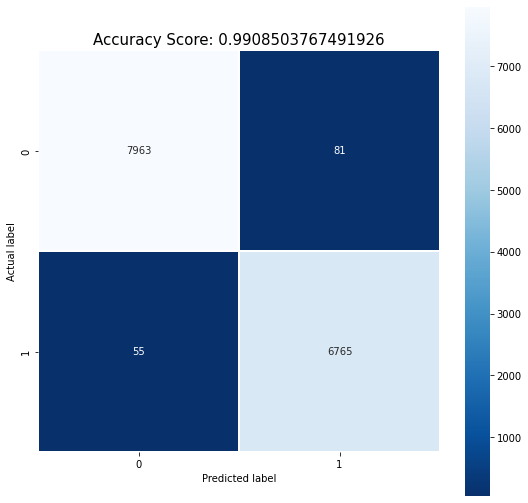

In [19]:
test_predictions = LR_classifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig('./LR_test_ACC')

# Get Probabilities on full dataset


In [20]:
full_predictions = LR_classifier.predict(np.array(list(word_df['represention'])))
score = LR_classifier.score(np.array(list(word_df['represention'])), word_df['label'].to_numpy())
print(score)

0.9922763297764979


In [21]:
print(metrics.classification_report(word_df['label'].to_numpy(), full_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9943    0.9914    0.9929     40339
           1     0.9899    0.9933    0.9916     33978

    accuracy                         0.9923     74317
   macro avg     0.9921    0.9924    0.9922     74317
weighted avg     0.9923    0.9923    0.9923     74317



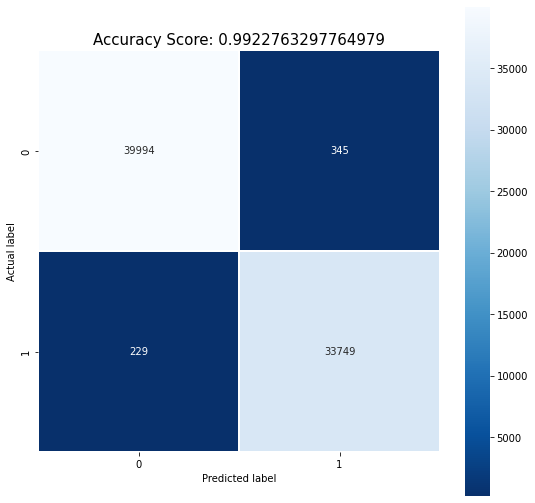

In [22]:
cm = metrics.confusion_matrix(word_df['label'].to_numpy(), full_predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig('./LR_full_ACC')

In [23]:
full_dataset_predictions = LR_classifier.predict_proba(np.array(list(word_df['represention'])))

In [24]:
word_df['word_prob'] = full_dataset_predictions[:,1]
word_df['nword_prob'] = full_dataset_predictions[:,0]

In [25]:
word_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                          nword_prob  \
              mean       std  count       max           min       mean   
category                                                                 
HF        0.990381  0.057240  14333  1.000000  1.441218e-05   0.009619   
LF        0.980176  0.084749  19645  1.000000  1.330814e-04   0.019824   
NW        0.012982  0.082958  40339  0.999998  3.715846e-16   0.987018   

                                               
               std  count       max       min  
category                                       
HF        0.057240  14333  0.999986  0.000000  
LF        0.084749  19645  0.999867  0.000000  
NW        0.082958  40339  1.000000  0.000002

In [26]:
word_df_to_save = word_df.drop(['represention'], axis=1)

In [27]:
word_df_to_save.to_csv(root+"Datasets/fastText_LR.csv", header=0, index=False)